<a href="https://colab.research.google.com/github/ArturoSirvent/TFG_notebooks/blob/main/Models_multiinput/ensemble_modelos_nuevoconmodificaciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensenble de modelos
Y si intentamos que lo unico que tenga que hacer un modelo es diferenciar un tipo de particula y el resto.
Si esto lo hacen muy bien, pomos usar submodelos para esto y que al final se mezclen.


In [ ]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import os
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow.keras.backend as K

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# funcion de carga más personalizada

#primero funcion que carga los datos al darle unos telescopios y runs 
def load_data(npy_dir,tels=None,runs=None,indices_runs=None,only_names=False,ending=".npy",test_size=0.2):
    #aplicamos regular expresions para extraer los documentos deseados
    #usamos glob
    #si no pasamos ni los tesls ni las runs, deolvemos todos los arichivos
    #es poco optimo este uso de glob, pero es mas flexivo porque le puedo pasar los tels concretos y los runs concretos
    #si es return sin labels, nos devuelve todo, sin separar siquiera

    lista=[]
    if ((type(tels)==list) or (type(tels)==np.ndarray)):
        #primero miramos a ver si es una lista los telescopios
        for i in tels:
            for j in runs:
                regex=f"{npy_dir}/*_tel_{i}_run_{str(j).zfill(2)}_?{ending}"
                aux=glob.glob(regex)
                if aux:
                    lista.extend(aux)
                else:
                    #si no lo encuentra entonces nos saldra mal la cosa
                    print("ERROR")
                    print(f"Para {os.path.basename(npy_dir)} no se encuentra el {os.path.basename(regex)}.")
    else:
        for j in runs:
            regex=f"{npy_dir}/*_tel_{tels}_run_{str(j).zfill(2)}_?{ending}"
            aux=glob.glob(regex)
            if aux:
                lista.extend(aux)
            else:
                #si no lo encuentra entonces nos saldra mal la cosa
                print("ERROR")
                print(f"Para {os.path.basename(npy_dir)} no se encuentra el {os.path.basename(regex)}.")

    if only_names:
        return lista
    else:
        if indices_runs is not None:
            if indices_runs[0].size==0:
                no_salir=True
                i=1
                while no_salir:
                    if indices_runs[i].size==0:
                        i+=1
                    else:
                        lista_npy=np.load(lista[i])[indices_runs[i]]
                        no_salir=False
                        i+=1
                for m,k in enumerate(lista[i:]):
                    if indices_runs[m+1].size!= 0:
                        lista_npy=np.concatenate((lista_npy,np.load(k)[indices_runs[m+1]]),axis=0)
                return lista_npy
            else:
                lista_npy=np.load(lista[0])[indices_runs[0]]
                for m,k in enumerate(lista[1:]):
                    if indices_runs[m+1].size!= 0:
                        lista_npy=np.concatenate((lista_npy,np.load(k)[indices_runs[m+1]]),axis=0)
                return lista_npy

        else:
            lista_npy=np.load(lista[0])
            for m,k in enumerate(lista[1:]):
                lista_npy=np.concatenate((lista_npy,np.load(k)),axis=0)
            return lista_npy

#ahora tenemos que saber cuales son los elementos que se comparten entre todos los telescopios


def get_common_events(npy_dir_base,tels=None,run=None):
    #esta funcion nos sirve para obtener los indices de eventos comunes tal que 
    #esto es necesario para que las imagenes sean del mismo evento

    #TENEMOS QUE MIRAR PARA UNA RUN, TODOS LOS TELESCOPIOS QUE NOS INTERESEN,
    #SIN IMPORTAR EL ELEMENTO, SOLO LOS TELESCOPIOS DE LA RUN Y EL EMENTO QUE TOQUE
    lista=[]
    if (type(tels)==list) or (type(tels)==np.ndarray):
        #primero miramos a ver si es una lista los telescopios
        for i in tels:
            regex=f"{npy_dir_base}/id_eventos_*_tel_{i}_run_{str(run).zfill(2)}.npy"
            aux=glob.glob(regex)
            if aux:
                lista.append(np.load(aux[0]))
            else:
                #si no lo encuentra entonces nos saldra mal la cosa
                print("ERROR")
                print(f"Para {os.path.basename(npy_dir_base)} no se encuentra el {os.path.basename(regex)}.")
    else:
        print("ERROR")
        return None
    if len(tels)==1:
        eventos_comunes=lista[0]
    else:
        sets=[set(i) for i in lista]
        #devolvemos una lista de los INDICES de los eventos que SON COMUNES y podemos coger
        eventos_comunes=sorted(list(sets[0].intersection(*sets[1:])))
        del sets
    indices_master=[]
    for i,j in enumerate(tels):
        indices=[]
        for k in eventos_comunes:
            indices.append(np.where(lista[i]==k)[0][0])
        indices_master.append(np.array(indices))
    return np.array(indices_master)



#por ultimo la funcion que nos va a administrar toda la carga de datos, aqui es donde pondemos la funcion de elergir el numero de runs para cada elementos


def load_dataset_ensemble(base_dir,elementos_clasif,pre_name_folders="npy_",telescopios=None,lista_list_runs=None,elementos=None,test_size=0.2,same_quant=False):#,ponderaciones=None):
    #telescopios deb ser una lista , aunque solo haya uno 1
    #esta funcion es una version de load_dataset donde puedes escoger cuantas runs de cada elemento, tambien puedes escoger ninguna
    #tambien (como en la otra, puedes decidir que haya mas o menos las mismas de todas same_quant)
    #list_RUNS Ahora es una lista de listas
    #indicamos los elementos que queremos que sean tomados en cuenta, pero el resto se les pone una label igual

    if elementos==None:
        elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
    #para cada elemento y para cada RUN tenemos que indicar los eventos validos
    eventos_elementos=[]
    numero_eventos=[]
    for i,j in enumerate(elementos):
        dir_aux=f"{base_dir}/{pre_name_folders}{j}"
        eventos_runs=[]
        list_runs=lista_list_runs[i]
        aux_num_events=0
        for l,k in enumerate(list_runs):
            aux_events=get_common_events(dir_aux,tels=telescopios,run=k)
            print(j,k,list_runs,aux_events.shape)
            eventos_runs.append(aux_events)
            aux_num_events+=aux_events.shape[1]
        numero_eventos.append(aux_num_events)
        eventos_elementos.append(eventos_runs)
    #ahora tenemos los eventos que sí nos valen porque estan en todos los telescopios a considerar 
    x_train_list=[]
    x_test_list=[]
    print("_______________")
    last_aux_decider=0
    for l,k in enumerate(telescopios):
        for i,j in enumerate(elementos):
            dir_aux=f"{base_dir}/{pre_name_folders}{j}"
            list_runs=lista_list_runs[i]
            #TENEMOS QUE TENER UNA LISTA DE LOS INDICES QUE SÍ COMPARTEN ID, EL RESTO NO NOS INTERESA
            #lo que hacemos es pasarle una lista de los indices PARA:
            #PARA el elemento que toca y el telescopio qeu toca, para todas las runs que queremos 
            data_aux=load_data(dir_aux,tels=k,runs=list_runs,indices_runs=[m[l,:] for m in eventos_elementos[i]],only_names=False)
            if same_quant:
                media=int(np.median(numero_eventos))
                data_aux=data_aux[:media]
            print(j,k,data_aux.shape)
            if l==0:
                if j in elementos_clasif:
                    aux_decider=last_aux_decider+1
                    last_aux_decider+=1
                else:
                    aux_decider=0
            if (i==0) :
                if l==0:
                    label_size=data_aux.shape[0]
                    labels=np.ones(label_size)*aux_decider
                data=data_aux
            else:
                if l==0:
                    label_size=data_aux.shape[0]
                    labels=np.concatenate((labels,np.ones(label_size)*aux_decider),axis=0)
                data=np.concatenate((data,data_aux),axis=0)
                del data_aux
        #print(data.shape)
        #ahora le aumentamos el canal y las labels las volvemos categorical
        data=data[...,np.newaxis]
        if l==0:
            labels=tf.keras.utils.to_categorical(labels)
            x_train,x_test,y_train,y_test =train_test_split(data,labels,test_size=test_size,random_state=42)
            del data,labels
            y_train_list=y_train
            y_test_list=y_test
            x_train_list.append(x_train)
            x_test_list.append(x_test)
            #del y_train,y_test
        else:
            x_train,x_test =train_test_split(data,test_size=test_size,random_state=42)
            x_train_list.append(x_train)
            x_test_list.append(x_test)
            del data
        #del x_train,x_test

    if (x_train.shape[0]!=y_train.shape[0]) or (x_test.shape[0]!=y_test.shape[0]):
        print("Ha habido algún problema con las dimensiones y eso...te jodes lo siento")
        return None
    else:
        print("EXITO")
        if len(telescopios)==1:
            return x_train_list[0],x_test_list[0],y_train_list,y_test_list
        else:
            return x_train_list,x_test_list,y_train_list,y_test_list



In [ ]:
def print_conf_matrix(matrix,elements=None,sin_diag=True):
    if elements is None:
        elements=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
    if sin_diag:
        for i in range(len(elements)):
            matrix[i,i]=0
    plt.figure(figsize=(13,13))
    sns.heatmap(matrix,annot=True)

    plt.yticks(np.arange(len(elements))+0.25,elements,fontsize=14,rotation=45);
    plt.xticks(np.arange(len(elements))+0.25,elements,fontsize=14,rotation=45);
    plt.title("True label en el eje Y, predicted en el eje X", fontsize=15)

In [ ]:
def comp_and_diplay_conf_matrix(y_test,y_predict,elements=None,sin_diag=True):
    matrix=confusion_matrix(np.argmax(y_test,axis=-1),np.argmax(y_predict,axis=-1))
    print_conf_matrix(matrix,elements=elements,sin_diag=sin_diag)

In [ ]:
#una funcion para crear la lista de list runs 
def create_lista_list_runs(num_events,init_events=None,random_select=False,elementos=None,max_runs=None):
    #solo tenemos que indicar la cantidad de runs que queremos de cada uno de los elementos
    #tambien podemos indicar el numero maximo de runs disponibles y si los queremos aleatorios
    if type(init_events)==int:
        if init_events==0:
            init_events=1
        init_events=np.ones(len(num_events))*init_events
    if elementos is None:
        elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
    if max_runs is None:
        max_runs=[41,40,40,40,20,40,40]
    lista_master=[]
    for i,j in enumerate(num_events):
        if random_select:
            if j> max_runs[i]:
                print("No hay tantas runs.")
                list_aux=np.random.randint(low=1,high=max_runs[i]+1,size=max_runs[i])
            else:
                list_aux=np.random.randint(low=1,high=max_runs[i]+1,size=j)
        else: 
            if init_events is not None:
                if (j+init_events[i]+1)> max_runs[i]:
                    print(f"Error, para el {i} te estas pasando de run, no hay runs {np.arange(max_runs[i]+1,init_events[i]+j+2,dtype=int)}")
                    if init_events[i] > max_runs[i]:
                        list_aux=np.random.randint(low=1,high=max_runs[i]+1,size=j)
                    else:
                        list_aux=np.arange(init_events[i],1+max_runs[i],dtype=int)
                else:
                    list_aux=np.arange(init_events[i],j+init_events[i],dtype=int)


            else:
                if (j+1) > max_runs[i]:
                    print(f"Error, para el \"{i}\" te estas pasando de run, no hay run {np.arange(max_runs[i]+1,j+2,dtype=int)}")
                    list_aux=np.arange(1,max_runs[i]+1,dtype=int)
                else:
                    list_aux=np.arange(1,j+1,dtype=int)
        lista_master.append(list_aux)
    return np.array(lista_master,dtype=object)


In [ ]:
#MODIFICACION PARA QUE HAYA MAS O MENOS LA MISMA CANTIDAD DE DATOS DE CADA UNO.
def load_dataset(base_dir,pre_name_folders="npy_",telescopios=None,list_runs=None,elementos=None,test_size=0.2,normalizacion_mal=False,same_quant=True):#,ponderaciones=None):
    #telescopios deb ser una lista , aunque solo haya uno 1
    if elementos==None:
        elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
    #para cada elemento y para cada RUN tenemos que indicar los eventos validos
    eventos_elementos=[]
    numero_eventos=[]
    for i,j in enumerate(elementos):
        dir_aux=f"{base_dir}/{pre_name_folders}{j}"
        eventos_runs=[]
        for l,k in enumerate(list_runs):
            aux_events=get_common_events(dir_aux,tels=telescopios,run=k)
            eventos_runs.append(aux_events)
            numero_eventos.append(aux_events.shape[1])
        eventos_elementos.append(eventos_runs)

    #ahora tenemos los eventos que sí nos valen porque estan en todos los telescopios a considerar 
    x_train_list=[]
    x_test_list=[]
    #prueba=ponderaciones
    for l,k in enumerate(telescopios):
        for i,j in enumerate(elementos):
            dir_aux=f"{base_dir}/{pre_name_folders}{j}"
            #TENEMOS QUE TENER UNA LISTA DE LOS INDICES QUE SÍ COMPARTEN ID, EL RESTO NO NOS INTERESA
            #lo que hacemos es pasarle una lista de los indices PARA:
            #PARA el elemento que toca y el telescopio qeu toca, para todas las runs que queremos 
            if same_quant:
                #aux_quant=int(np.median(numero_eventos))
                aux_quant=int(sorted(numero_eventos)[-4])
                data_aux=load_data(dir_aux,tels=k,runs=list_runs,indices_runs=[m[l,:aux_quant] for m in eventos_elementos[i]],only_names=False)
            else:
                data_aux=load_data(dir_aux,tels=k,runs=list_runs,indices_runs=[m[l,:] for m in eventos_elementos[i]],only_names=False)
            print(data_aux.shape)
            if normalizacion_mal:
                maximo_aux=np.amax(data_aux)
            else:
                maximo_aux=1
            if (i==0) :
                if l==0:
                    label_size=data_aux.shape[0]
                    labels=np.zeros(label_size)
                data=data_aux/maximo_aux
                del data_aux
            else:
                if l==0:
                    label_size=data_aux.shape[0]
                    labels=np.concatenate((labels,np.ones(label_size)*i),axis=0)
                data=np.concatenate((data,data_aux/maximo_aux),axis=0)
                del data_aux
        #print(data.shape)
        #ahora le aumentamos el canal y las labels las volvemos categorical
        data=data[...,np.newaxis]
        if l==0:
            labels=tf.keras.utils.to_categorical(labels)
            x_train,x_test,y_train,y_test =train_test_split(data,labels,test_size=test_size,random_state=42)
            del data,labels
            y_train_list=y_train
            y_test_list=y_test
            x_train_list.append(x_train)
            x_test_list.append(x_test)
            #del y_train,y_test
        else:
            x_train,x_test =train_test_split(data,test_size=test_size,random_state=42)
            x_train_list.append(x_train)
            x_test_list.append(x_test)
        #del x_train,x_test

    if (x_train.shape[0]!=y_train.shape[0]) or (x_test.shape[0]!=y_test.shape[0]):
        print("Ha habido algún problema con las dimensiones y eso...te jodes lo siento")
        return None
    else:
        print("EXITO")
        if len(telescopios)==1:
            return x_train_list[0],x_test_list[0],y_train_list,y_test_list
        else:
            return x_train_list,x_test_list,y_train_list,y_test_list



In [ ]:
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"
a=create_lista_list_runs(num_events=[1,1,1,1,1,1,1],random_select=False)
x_train,x_test,y_train,y_test=load_dataset_ensemble(npy_base,["electron","gamma"],telescopios=[6,11,4,5],lista_list_runs=a,test_size=0.17,same_quant=True)


gamma 1 [1] (4, 1999)


KeyboardInterrupt: ignored

Model: "prueba_red"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 84, 56, 1)]  0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 84, 56, 1)]  0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 55, 93, 1)]  0                                            
_________________________________________________________________________________________

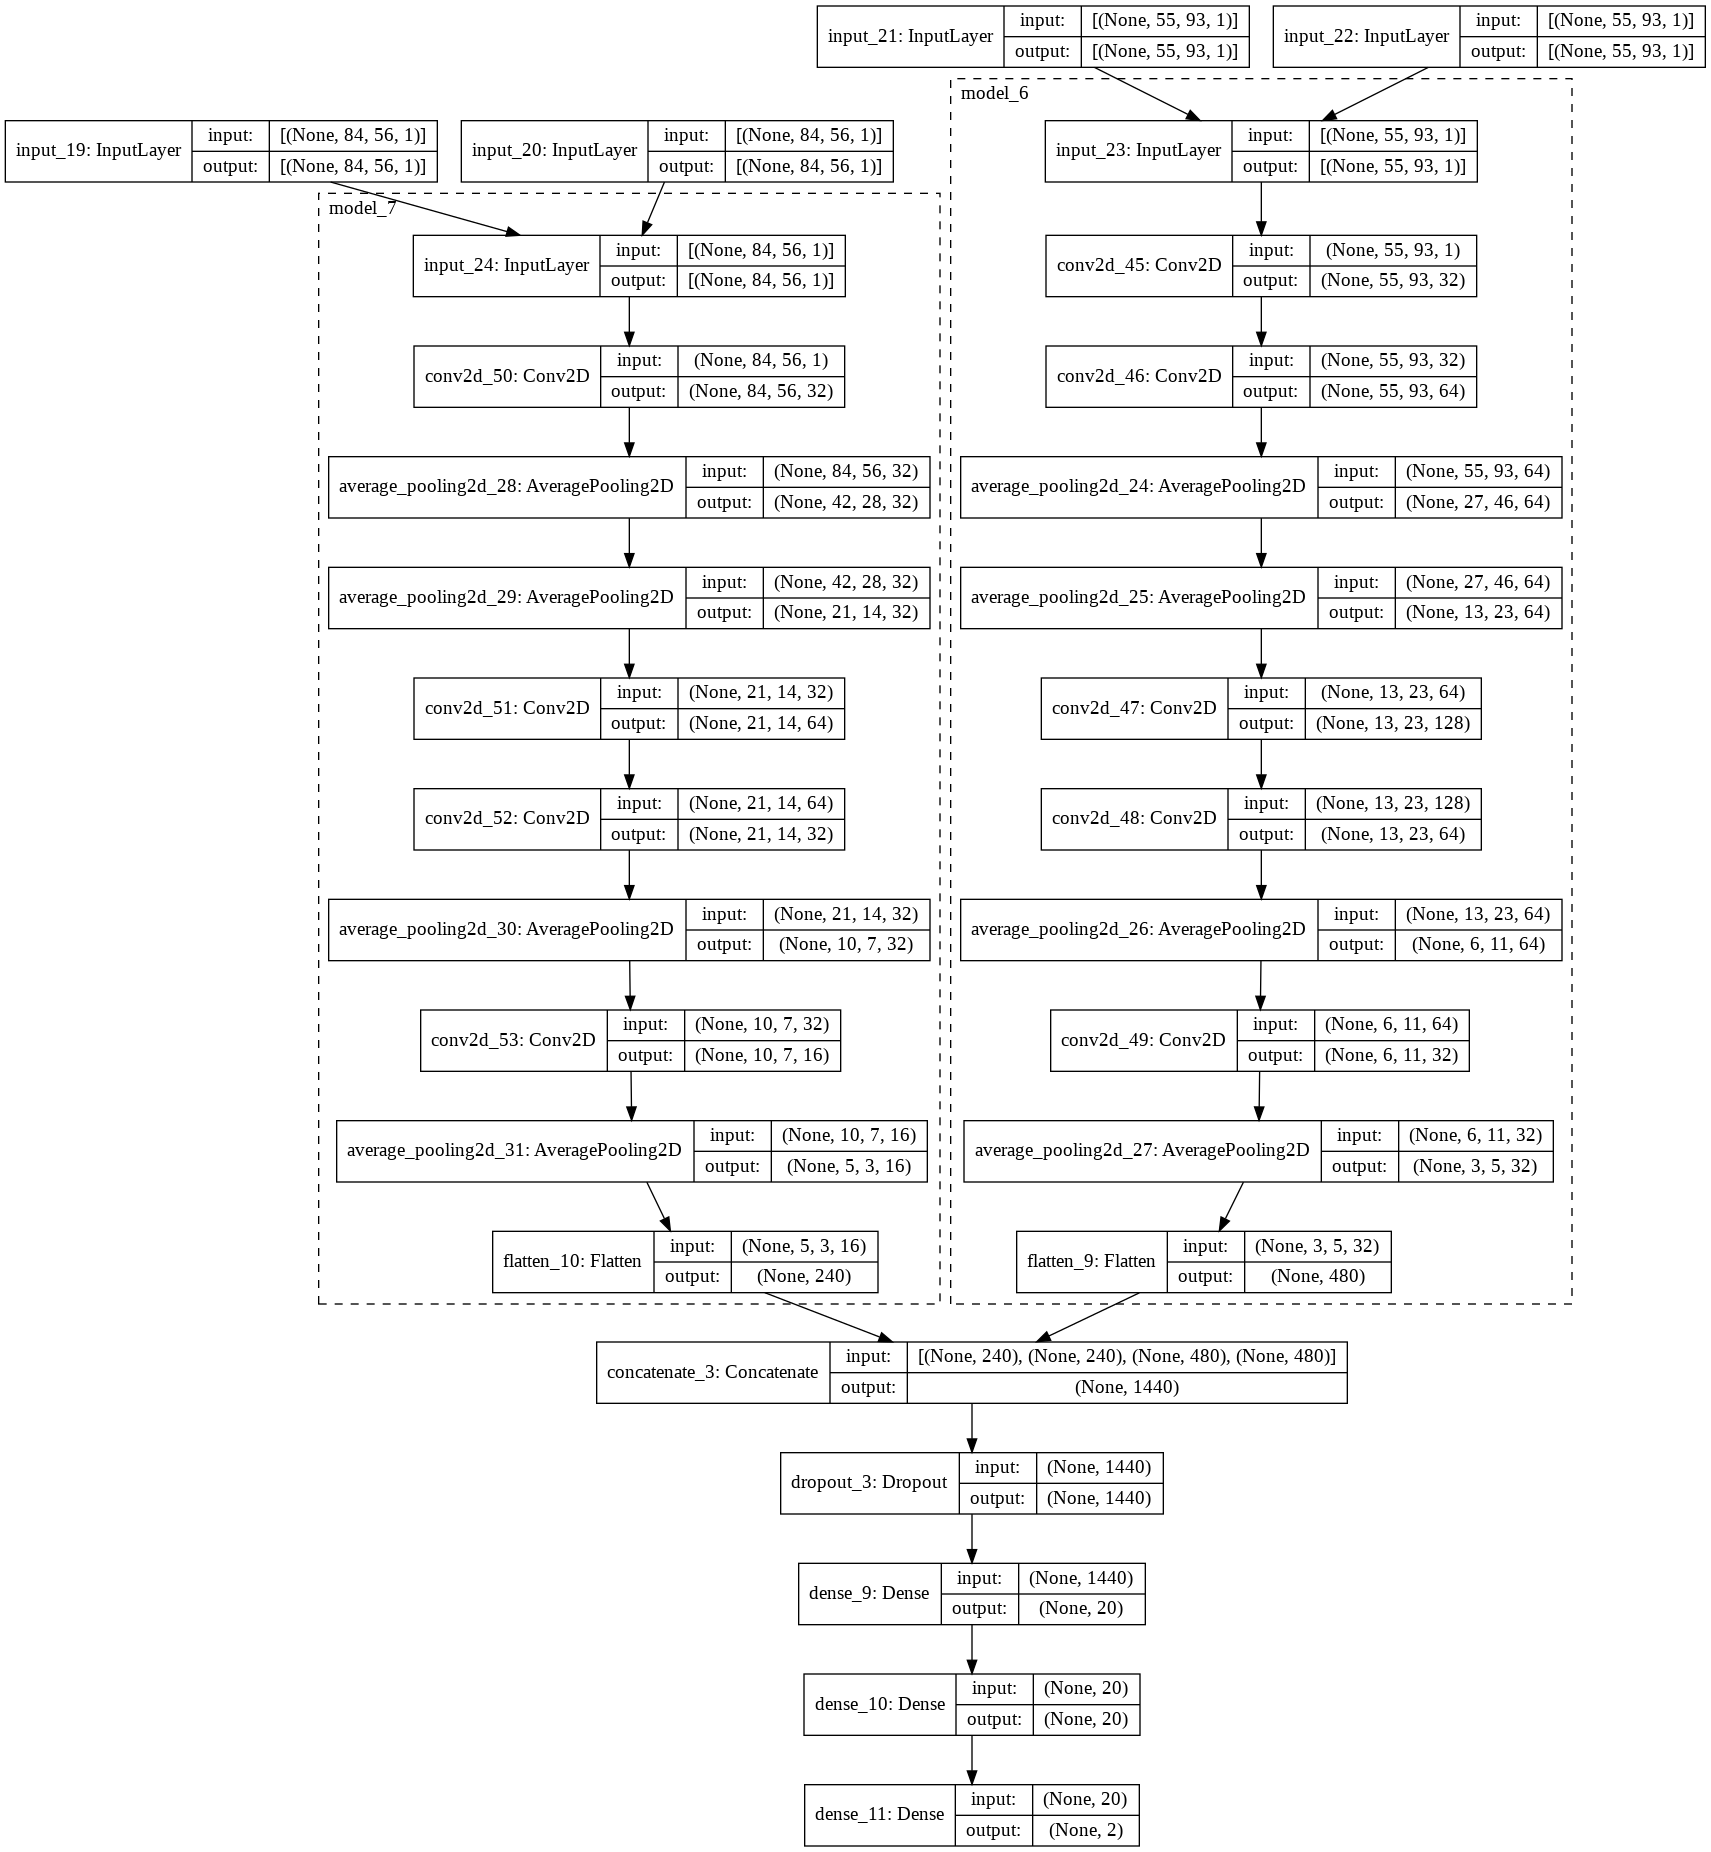

In [ ]:
#vamos a crear un modelo que nos distinga entre estos dos y el resto
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"

#creamos el model de zero
#tenemos 4 inputs
telesc=4
clases=2 #elect,gamma y resto
input1=tf.keras.Input(shape=(84,56,1))
input2=tf.keras.Input(shape=(84,56,1))
input3=tf.keras.Input(shape=(55,93,1))
input4=tf.keras.Input(shape=(55,93,1))

#autoencoder=tf.keras.models.load_model(f"{npy_base}/autoencoder_bien.h5")
#autoencoder.trainable=False
#entran los 4 inputs y nos dan 4 outputs diferentes

#output1=autoencoder(input1)
#output2=autoencoder(input2)
#output3=autoencoder(input3)
#output4=autoencoder(input4)

#ahora los outputs los procesamos tal que todos se procesan por el mismo submodelo
aux_input=tf.keras.Input(shape=(55,93,1))
x=tf.keras.layers.BatchNormalization()(aux_input)
x=tf.keras.layers.Activation("relu")(x)
x=tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu")(aux_input)
x=tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
x=tf.keras.layers.AveragePooling2D((2,2))(x)
x=tf.keras.layers.AveragePooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(128,(3,3),padding="same",activation="relu")(x)
x=tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
x=tf.keras.layers.AveragePooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
x=tf.keras.layers.AveragePooling2D((2,2))(x)
x=tf.keras.layers.Flatten()(x)
submodel_conv=tf.keras.Model(inputs=aux_input,outputs=x)

#submodel para los de 84,56
aux_input2=tf.keras.Input(shape=(84,56,1))
x=tf.keras.layers.BatchNormalization()(aux_input2)
x=tf.keras.layers.Activation("relu")(x)
x=tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu")(aux_input2)
#x=tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
x=tf.keras.layers.AveragePooling2D((2,2))(x)
x=tf.keras.layers.AveragePooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
x=tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
x=tf.keras.layers.AveragePooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(16,(3,3),padding="same",activation="relu")(x)
x=tf.keras.layers.AveragePooling2D((2,2))(x)
x=tf.keras.layers.Flatten()(x)
submodel_conv_2=tf.keras.Model(inputs=aux_input2,outputs=x)



modelito = tf.keras.models.Sequential([tf.keras.layers.Conv2D(64, 7, activation="relu", padding="same",input_shape=[55, 93, 1]),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten()])
#modelito.summary()



final_output1=submodel_conv_2(input1)
final_output2=submodel_conv_2(input2)
final_output3=submodel_conv(input3)
final_output4=submodel_conv(input4)

end_layer=tf.keras.layers.concatenate([final_output1,final_output2,final_output3,final_output4])
end_layer=tf.keras.layers.Dropout(0.5)(end_layer)
end_layer=tf.keras.layers.Dense(20,activation="relu",kernel_regularizer="l2")(end_layer)
end_layer=tf.keras.layers.Dense(20,activation="relu",kernel_regularizer="l2")(end_layer)
end_layer=tf.keras.layers.Dense(clases,activation="softmax")(end_layer)
model=tf.keras.Model(inputs=[input1,input2,input3,input4],outputs=end_layer,name="prueba_red")
model.summary()
tf.keras.utils.plot_model(model,expand_nested=True,show_shapes=True)

In [ ]:
import sys 
for a in vars().keys():
    print(a,sys.getsizeof(vars()[a]))

__name__ 57
__doc__ 113
__package__ 16
__loader__ 16
__spec__ 16
__builtin__ 72
__builtins__ 72
_ih 192
_oh 232
_dh 64
In 192
Out 232
get_ipython 64
exit 48
quit 48
_ 2272
__ 49
___ 49
_i 1036
_ii 2620
_iii 78
_i1 324
tf 72
np 72
plt 72
os 72
glob 72
train_test_split 136
pd 72
K 72
confusion_matrix 136
sns 72
load_data 136
get_common_events 136
load_dataset_ensemble 136
_i3 608
print_conf_matrix 136
_i4 277
comp_and_diplay_conf_matrix 136
_i5 2026
create_lista_list_runs 136
_i6 2586
npy_base 102
telesc 28
clases 28
input1 48
input2 48
input3 48
input4 48
aux_input 48
x 48
submodel_conv 48
modelito 48
final_output1 48
final_output2 48
final_output3 48
final_output4 48
end_layer 48
_i7 1036
elementos 112
stop 48
hist_master 56
bat 28
i 24
a 50
x_test 88
y_test 16320
_i8 55
_8 2272
_i9 90
sys 72
_i10 105
_i11 121
_i12 122
_i13 78
_i14 2620
model 48
_i15 1036
x_train 88
y_train 91952
_i16 122


In [ ]:
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"
lista=os.listdir(f"{npy_base}/npy_electron")

In [ ]:
a=np.load(f"{npy_base}/npy_electron/{lista[1]}")

In [ ]:
a.shape

(147, 84, 56)

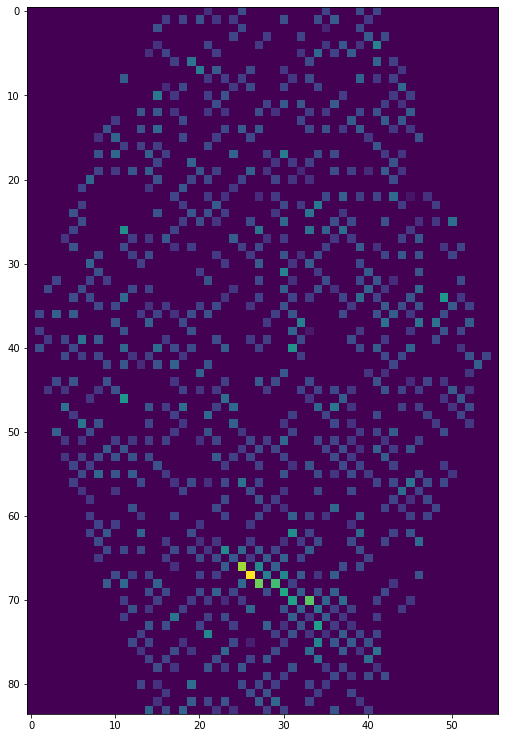

In [ ]:
plt.figure(figsize=(13,13))
plt.imshow(a[3])

In [ ]:
a=create_lista_list_runs(num_events=[1,4,5,6,3,3,3],random_select=False)

x_train,x_test,y_train,y_test=load_dataset_ensemble(npy_base,['proton'],telescopios=[34],lista_list_runs=a,test_size=0.15,same_quant=False) 


gamma 1 [1] (1, 850)
electron 1 [1 2 3 4] (1, 175)
electron 2 [1 2 3 4] (1, 162)
electron 3 [1 2 3 4] (1, 164)
electron 4 [1 2 3 4] (1, 178)
proton 1 [1 2 3 4 5] (1, 226)
proton 2 [1 2 3 4 5] (1, 205)
proton 3 [1 2 3 4 5] (1, 228)
proton 4 [1 2 3 4 5] (1, 228)
proton 5 [1 2 3 4 5] (1, 211)
helium 1 [1 2 3 4 5 6] (1, 153)
helium 2 [1 2 3 4 5 6] (1, 159)
helium 3 [1 2 3 4 5 6] (1, 143)
helium 4 [1 2 3 4 5 6] (1, 164)
helium 5 [1 2 3 4 5 6] (1, 179)
helium 6 [1 2 3 4 5 6] (1, 184)
iron 1 [1 2 3] (1, 116)
iron 2 [1 2 3] (1, 145)
iron 3 [1 2 3] (1, 153)
nitrogen 1 [1 2 3] (1, 93)
nitrogen 2 [1 2 3] (1, 90)
nitrogen 3 [1 2 3] (1, 101)
silicon 1 [1 2 3] (1, 110)
silicon 2 [1 2 3] (1, 109)
silicon 3 [1 2 3] (1, 112)
_______________
gamma 34 (850, 84, 56)
electron 34 (679, 84, 56)
proton 34 (1098, 84, 56)
helium 34 (982, 84, 56)
iron 34 (414, 84, 56)
nitrogen 34 (284, 84, 56)
silicon 34 (331, 84, 56)
EXITO


In [ ]:
#este es el error que estamos teniendo
a=np.array([1,2,4])
#a[np.array([])]
#arrays used as indices must be of integer (or boolean) type


array([[1, 2, 4]])

In [ ]:
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"
elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
#hacemos un bucle que nos entrene atraves de muchas iteraciones
stop=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=6)
hist_master=[]
bat=32
for i in range(9):
    if i==2:
        bat=64
        #model.compile(optimizer=tf.keras.optimizers.Adam(1e-7),loss="categorical_crossentropy",metrics=["accuracy"])
    a=create_lista_list_runs(num_events=[1,4,5,6,3,3,3],init_events=(1+i*2),random_select=False)
    x_train,x_test,y_train,y_test=load_dataset_ensemble(npy_base,['proton',"nitrogen"],telescopios=[31,32,4,5],lista_list_runs=a,test_size=0.15,same_quant=False) 
    hist=model.fit(x_train,y_train,epochs=5,batch_size=bat,validation_data=(x_test,y_test),callbacks=[stop])
    hist_master.append(hist)

gamma 1 [1] (4, 610)
electron 1 [1 2 3 4] (4, 40)
electron 2 [1 2 3 4] (4, 37)
electron 3 [1 2 3 4] (4, 34)
electron 4 [1 2 3 4] (4, 39)
proton 1 [1 2 3 4 5] (4, 34)
proton 2 [1 2 3 4 5] (4, 28)
proton 3 [1 2 3 4 5] (4, 24)
proton 4 [1 2 3 4 5] (4, 21)
proton 5 [1 2 3 4 5] (4, 25)
helium 1 [1 2 3 4 5 6] (4, 13)
helium 2 [1 2 3 4 5 6] (4, 15)
helium 3 [1 2 3 4 5 6] (4, 19)
helium 4 [1 2 3 4 5 6] (4, 24)
helium 5 [1 2 3 4 5 6] (4, 19)
helium 6 [1 2 3 4 5 6] (4, 24)
iron 1 [1 2 3] (4, 2)
iron 2 [1 2 3] (4, 0)
iron 3 [1 2 3] (4, 1)
nitrogen 1 [1 2 3] (4, 13)
nitrogen 2 [1 2 3] (4, 11)
nitrogen 3 [1 2 3] (4, 7)
silicon 1 [1 2 3] (4, 10)
silicon 2 [1 2 3] (4, 9)
silicon 3 [1 2 3] (4, 5)
_______________
gamma 31 (610, 84, 56)
electron 31 (150, 84, 56)
proton 31 (132, 84, 56)
helium 31 (114, 84, 56)
iron 31 (3, 84, 56)
nitrogen 31 (31, 84, 56)
silicon 31 (24, 84, 56)
gamma 32 (610, 84, 56)
electron 32 (150, 84, 56)
proton 32 (132, 84, 56)
helium 32 (114, 84, 56)
iron 32 (3, 84, 56)
nitrogen 32

KeyboardInterrupt: ignored

In [ ]:
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/ensemble"
model.save(f"{npy_base}/otros_proton_nitrogen_31_32_4_5.h5")

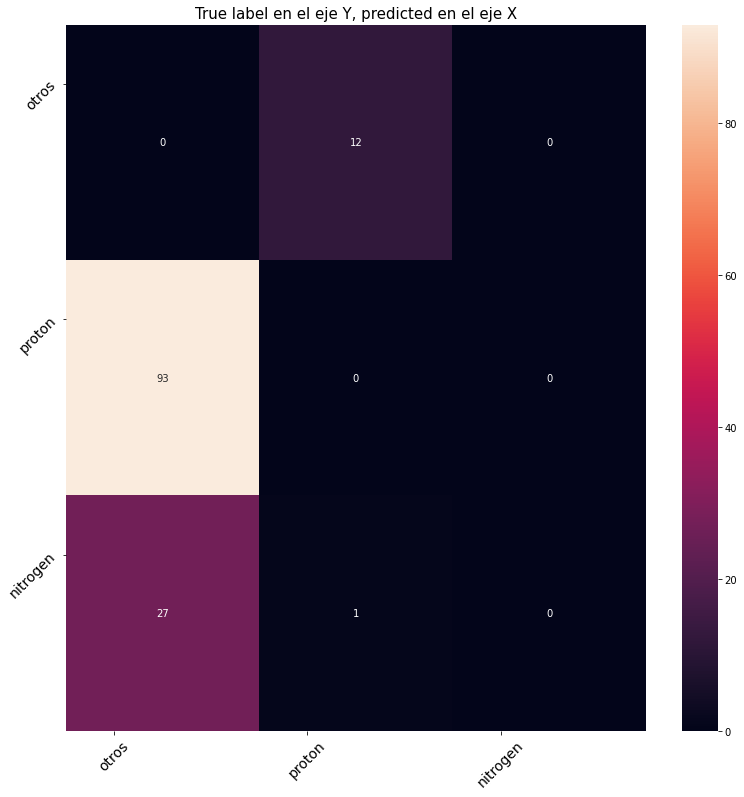

In [ ]:
comp_and_diplay_conf_matrix(y_train,model.predict(x_train),elements=["otros",'proton',"nitrogen"])

In [ ]:
(x_train[1].shape[0]-330*2-300)/x_train[1].shape[0]

0.8342827550491974

vamos a hacer los modelos para el ensemble, los 7 modelos que reconozcan los direferentes tipos

In [ ]:
def crear_modelo():
    #vamos a crear un modelo que nos distinga entre estos dos y el resto
    npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"

    #creamos el model de zero
    #tenemos 4 inputs
    telesc=4
    clases=2 #elect,gamma y resto
    input1=tf.keras.Input(shape=(55,93,1))
    input2=tf.keras.Input(shape=(55,93,1))
    input3=tf.keras.Input(shape=(55,93,1))
    input4=tf.keras.Input(shape=(55,93,1))

    #autoencoder=tf.keras.models.load_model(f"{npy_base}/autoencoder_bien.h5")
    #autoencoder.trainable=False
    #entran los 4 inputs y nos dan 4 outputs diferentes

    #output1=autoencoder(input1)
    #output2=autoencoder(input2)
    #output3=autoencoder(input3)
    #outpmodel=tf.keras.models.load_model(f"{save_dir}/{elementos[5]}_ensemble_1.h5")ut4=autoencoder(input4)

    #ahora los outputs los procesamos tal que todos se procesan por el mismo submodelo
    aux_input=tf.keras.Input(shape=(55,93,1))
    x=tf.keras.layers.BatchNormalization()(aux_input)
    x=tf.keras.layers.Activation("relu")(x)
    x=tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu")(aux_input)
    x=tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
    x=tf.keras.layers.AveragePooling2D((2,2))(x)
    x=tf.keras.layers.AveragePooling2D((2,2))(x)
    x=tf.keras.layers.Conv2D(128,(3,3),padding="same",activation="relu")(x)
    x=tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
    x=tf.keras.layers.AveragePooling2D((2,2))(x)
    x=tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
    x=tf.keras.layers.AveragePooling2D((2,2))(x)
    x=tf.keras.layers.Flatten()(x)
    submodel_conv=tf.keras.Model(inputs=aux_input,outputs=x)

    #submodel para los de 84,56
    aux_input2=tf.keras.Input(shape=(84,56,1))
    x=tf.keras.layers.BatchNormalization()(aux_input2)
    x=tf.keras.layers.Activation("relu")(x)
    x=tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu")(aux_input2)
    #x=tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
    x=tf.keras.layers.AveragePooling2D((2,2))(x)
    x=tf.keras.layers.AveragePooling2D((2,2))(x)
    x=tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
    x=tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
    x=tf.keras.layers.AveragePooling2D((2,2))(x)
    x=tf.keras.layers.Conv2D(16,(3,3),padding="same",activation="relu")(x)
    x=tf.keras.layers.AveragePooling2D((2,2))(x)
    x=tf.keras.layers.Flatten()(x)
    submodel_conv_2=tf.keras.Model(inputs=aux_input2,outputs=x)



    modelito = tf.keras.models.Sequential([tf.keras.layers.Conv2D(64, 7, activation="relu", padding="same",input_shape=[55, 93, 1]),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
        tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
        tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
        tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten()])
    #modelito.summary()



    final_output1=submodel_conv(input1)
    final_output2=submodel_conv(input2)
    final_output3=submodel_conv(input3)
    final_output4=submodel_conv(input4)

    end_layer=tf.keras.layers.concatenate([final_output1,final_output2,final_output3,final_output4])
    end_layer=tf.keras.layers.Dropout(0.5)(end_layer)
    end_layer=tf.keras.layers.Dense(20,activation="relu",kernel_regularizer="l2")(end_layer)
    end_layer=tf.keras.layers.Dense(20,activation="relu",kernel_regularizer="l2")(end_layer)
    end_layer=tf.keras.layers.Dense(clases,activation="softmax")(end_layer)
    model=tf.keras.Model(inputs=[input1,input2,input3,input4],outputs=end_layer,name="prueba_red")
    return model

In [ ]:
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"
save_dir="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/ensemble"
elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
element_aux=['helium', 'iron', 'nitrogen', 'silicon']

event_aux=np.ones(len(elementos))*20
event_aux[4]=1
stop=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=7)
for k,l in enumerate(element_aux):
    print(l)
    events=[1,2,2,2,2,2,2]
    #if k ==0:
        #model=crear_modelo()
        #model=tf.keras.models.load_model(f"{save_dir}/{elementos[0]}_ensemble_2.h5")
    #else:
    model=tf.keras.models.load_model(f"{save_dir}/{element_aux[k]}_ensemble_2.h5")
    model.compile(optimizer=tf.keras.optimizers.Adam(6e-5),loss="categorical_crossentropy",metrics=["accuracy"])
    #hacemos un bucle que nos entrene atraves de muchas iteraciones
    bat=64
    
    events[k+3]=13
    for i in range(7):
        if i==3:
            bat=128
            model.compile(optimizer=tf.keras.optimizers.Adam(1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
        a=create_lista_list_runs(num_events=events,init_events=[t+i*2 for t in event_aux],random_select=False)
        if i<5:
            b=False
        else:
            b=True
        x_train,x_test,y_train,y_test=load_dataset_ensemble(npy_base,[l],telescopios=[6,11,4,5],lista_list_runs=a,test_size=0.15,same_quant=b) 
        hist=model.fit(x_train,y_train,epochs=55,batch_size=bat,validation_data=(x_test,y_test),callbacks=[stop])
        model.save(f"{save_dir}/{l}_ensemble_2.h5")

helium
gamma 20 [20] (4, 1999)
electron 20 [20 21] (4, 119)
electron 21 [20 21] (4, 83)
proton 20 [20 21] (4, 365)
proton 21 [20 21] (4, 363)
helium 20 [20 21 22 23 24 25 26 27 28 29 30 31 32] (4, 254)
helium 21 [20 21 22 23 24 25 26 27 28 29 30 31 32] (4, 241)
helium 22 [20 21 22 23 24 25 26 27 28 29 30 31 32] (4, 238)
helium 23 [20 21 22 23 24 25 26 27 28 29 30 31 32] (4, 245)
helium 24 [20 21 22 23 24 25 26 27 28 29 30 31 32] (4, 240)
helium 25 [20 21 22 23 24 25 26 27 28 29 30 31 32] (4, 244)
helium 26 [20 21 22 23 24 25 26 27 28 29 30 31 32] (4, 239)
helium 27 [20 21 22 23 24 25 26 27 28 29 30 31 32] (4, 222)
helium 28 [20 21 22 23 24 25 26 27 28 29 30 31 32] (4, 232)
helium 29 [20 21 22 23 24 25 26 27 28 29 30 31 32] (4, 217)
helium 30 [20 21 22 23 24 25 26 27 28 29 30 31 32] (4, 235)
helium 31 [20 21 22 23 24 25 26 27 28 29 30 31 32] (4, 224)
helium 32 [20 21 22 23 24 25 26 27 28 29 30 31 32] (4, 234)
iron 1 [1 2] (4, 130)
iron 2 [1 2] (4, 126)
nitrogen 20 [20 21] (4, 101)
nitro

In [ ]:
#vamos  ver como de bien funciona el invento

#puede ser que no necesitemos tener modelos con todos los telescopio, dada la estructura de estos, podriamos buscar configuraciones equivalentes y 
#que uno entrenado en 4,5,32,31 sirva perfectamente para datos en 6,11,28,29 y asi

#cargamos los modelos
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"
save_dir="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/ensemble"
elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
modelos=[]
for i in elementos:
    modelos.append(tf.keras.models.load_model(f"{save_dir}/{i}_ensemble.h5"))

In [ ]:
#ahora que tenemos los modelos, haremos un bucle que nos indique los resultados de un input aplicado a todos

#cargamos datos
a=create_lista_list_runs(num_events=[1,7,7,7,7,7,7],random_select=True)
x_train,x_test,y_train,y_test=load_dataset_ensemble(npy_base,elementos_clasif=elementos[2],lista_list_runs=a,telescopios=[31,32,4,5],test_size=0.05) 




In [ ]:
#evaluamos todos los modelos
resultados=[]
x_input=[i[:5] for i in x_train]
y_input=y_train[:5]
for i,j in enumerate(elementos):
    resultados.append(modelos[i].predict(x_input))


In [ ]:
for i in range(len(resultados)):
    
    for j in range(len(x_input[1])):

        print(f"Modelo que predice {elementos[i]}, ha salido {resultados[i][j]} y \n es {elementos[np.argmax(y_input[j])]}")

In [ ]:
#lo anterior son muchos tipos de particulas, pero cada una nos da como resulado un si o no 
#lo que hacemos es para cada set de respuestas vamos a ver los elementos de la segunda columna y ver cual es 
#mayor

y_predicted=np.zeros(resultados[3].shape[0])
for i in range(resultados[3].shape[0]):
    #vamos a recorrer los modelos y ver cual tiene el mayor indice
    max=0
    for j in range(len(modelos)):
        if resultados[j][i][1]>max:
            y_predicted[i]=j
            max=resultados[j][i][1]



gamma 15 [15] (4, 1997)
electron 18 [18 37 28 35 39 23  7] (4, 122)
electron 37 [18 37 28 35 39 23  7] (4, 110)
electron 28 [18 37 28 35 39 23  7] (4, 112)
electron 35 [18 37 28 35 39 23  7] (4, 111)
electron 39 [18 37 28 35 39 23  7] (4, 108)
electron 23 [18 37 28 35 39 23  7] (4, 109)
electron 7 [18 37 28 35 39 23  7] (4, 111)
proton 20 [20 35 20  5 33 11  2] (4, 365)
proton 35 [20 35 20  5 33 11  2] (4, 345)
proton 20 [20 35 20  5 33 11  2] (4, 365)
proton 5 [20 35 20  5 33 11  2] (4, 371)
proton 33 [20 35 20  5 33 11  2] (4, 340)
proton 11 [20 35 20  5 33 11  2] (4, 363)
proton 2 [20 35 20  5 33 11  2] (4, 347)
helium 33 [33  7  2 23 31  7  4] (4, 242)
helium 7 [33  7  2 23 31  7  4] (4, 260)
helium 2 [33  7  2 23 31  7  4] (4, 249)
helium 23 [33  7  2 23 31  7  4] (4, 245)
helium 31 [33  7  2 23 31  7  4] (4, 224)
helium 7 [33  7  2 23 31  7  4] (4, 260)
helium 4 [33  7  2 23 31  7  4] (4, 267)
iron 15 [15 20 15  1  4  9 20] (4, 116)
iron 20 [15 20 15  1  4  9 20] (4, 154)
iron 15

<Figure size 432x288 with 0 Axes>

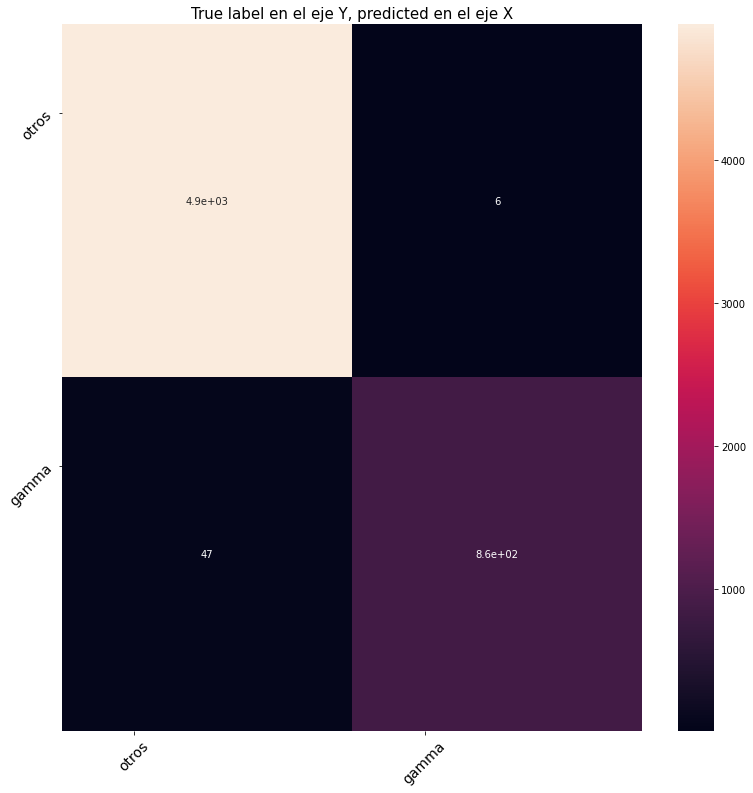

<Figure size 432x288 with 0 Axes>

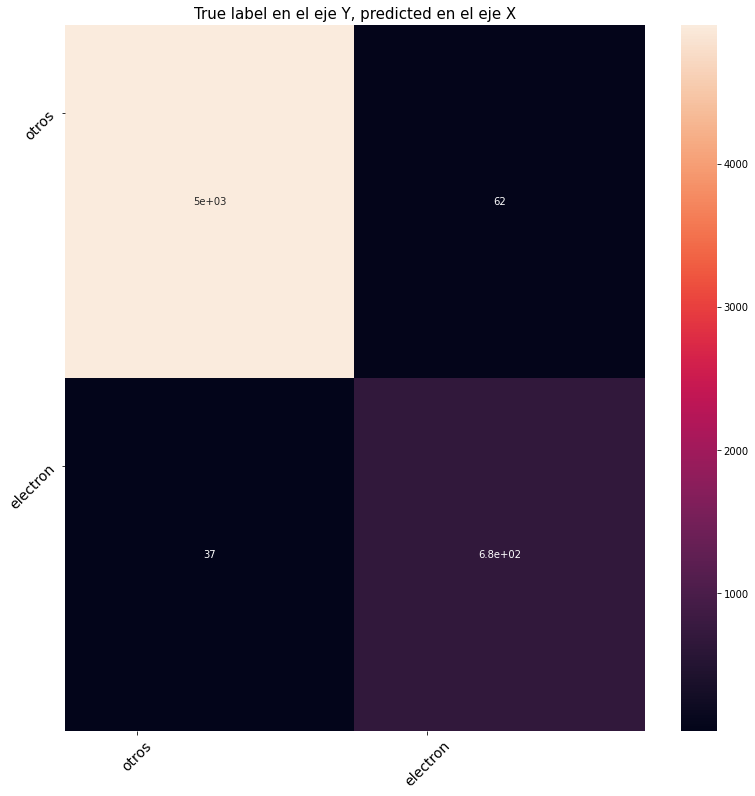

<Figure size 432x288 with 0 Axes>

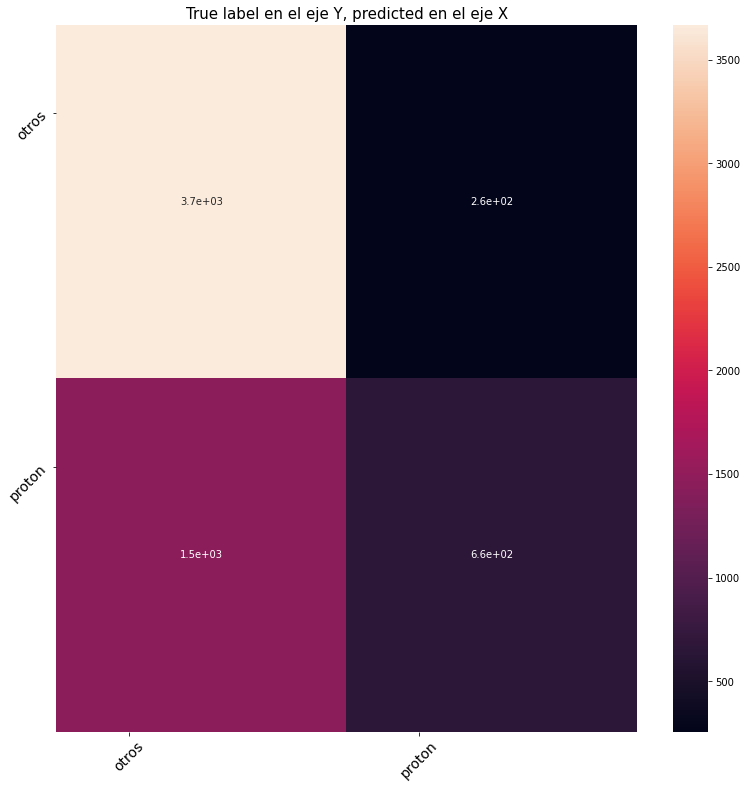

<Figure size 432x288 with 0 Axes>

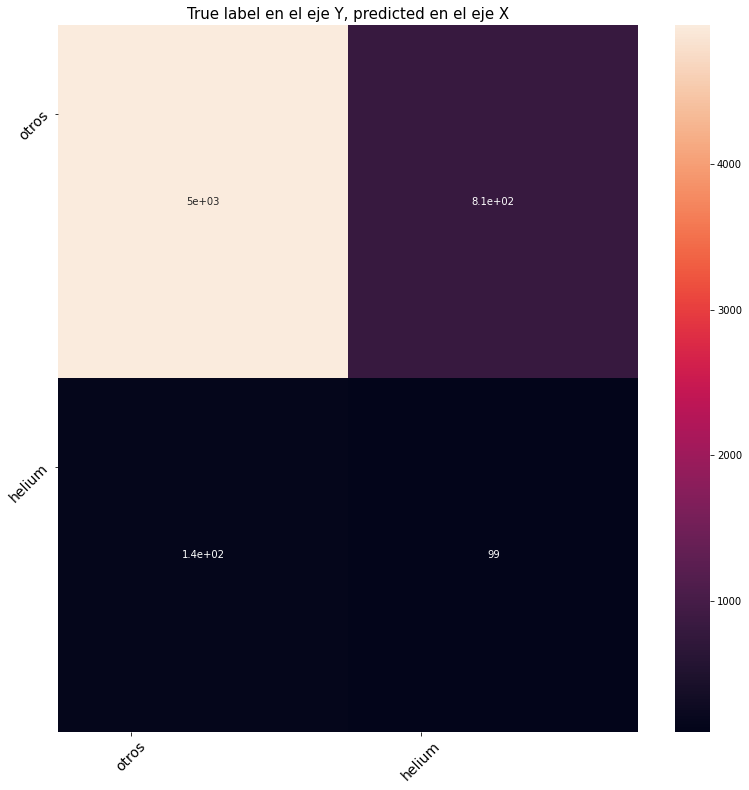

<Figure size 432x288 with 0 Axes>

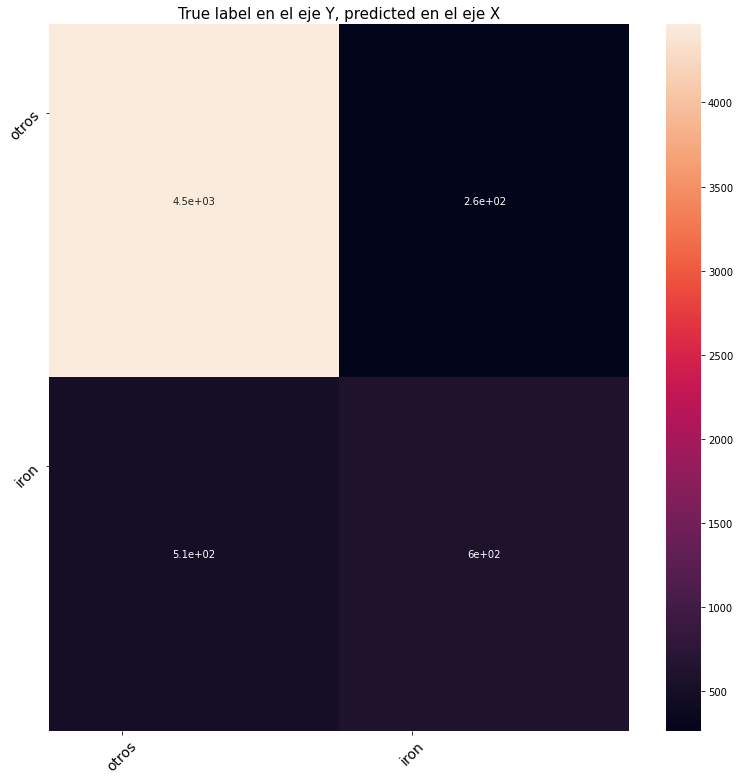

<Figure size 432x288 with 0 Axes>

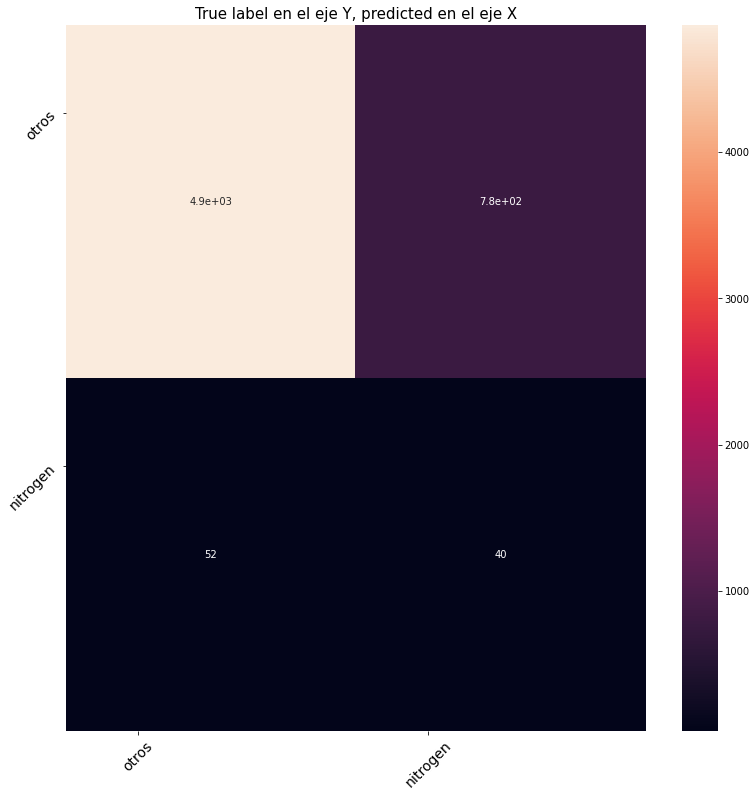

<Figure size 432x288 with 0 Axes>

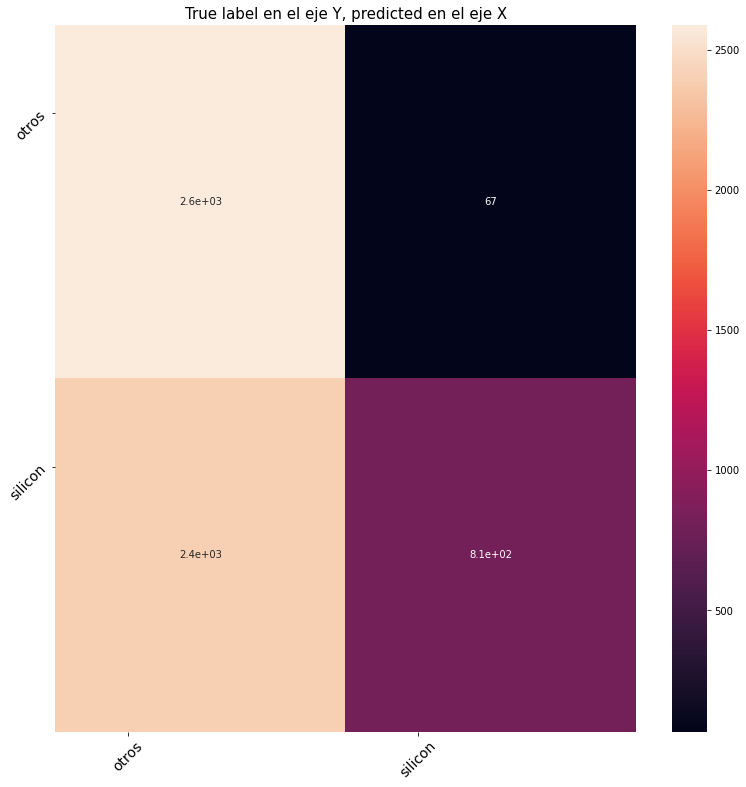

In [ ]:
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"
save_dir="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/ensemble"
elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
for i in range(len(elementos)):
    model=tf.keras.models.load_model(f"{save_dir}/{elementos[i]}_ensemble_2.h5")

    #ahora que tenemos los modelos, haremos un bucle que nos indique los resultados de un input aplicado a todos

    #cargamos datos
    a=create_lista_list_runs(num_events=[1,7,7,7,7,7,7],random_select=True)
    x_train,x_test,y_train,y_test=load_dataset_ensemble(npy_base,elementos_clasif=elementos[i],lista_list_runs=a,telescopios=[6,11,4,5],test_size=0.05,same_quant=True) 

    model.evaluate(x_train,y_train)
    salida=model.predict(x_train)
    plt.figure()
    comp_and_diplay_conf_matrix(salida,y_train,elements=["otros",elementos[i]],sin_diag=False)

Model: "prueba_red"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 55, 93, 1)]  0                                            
_________________________________________________________________________________________

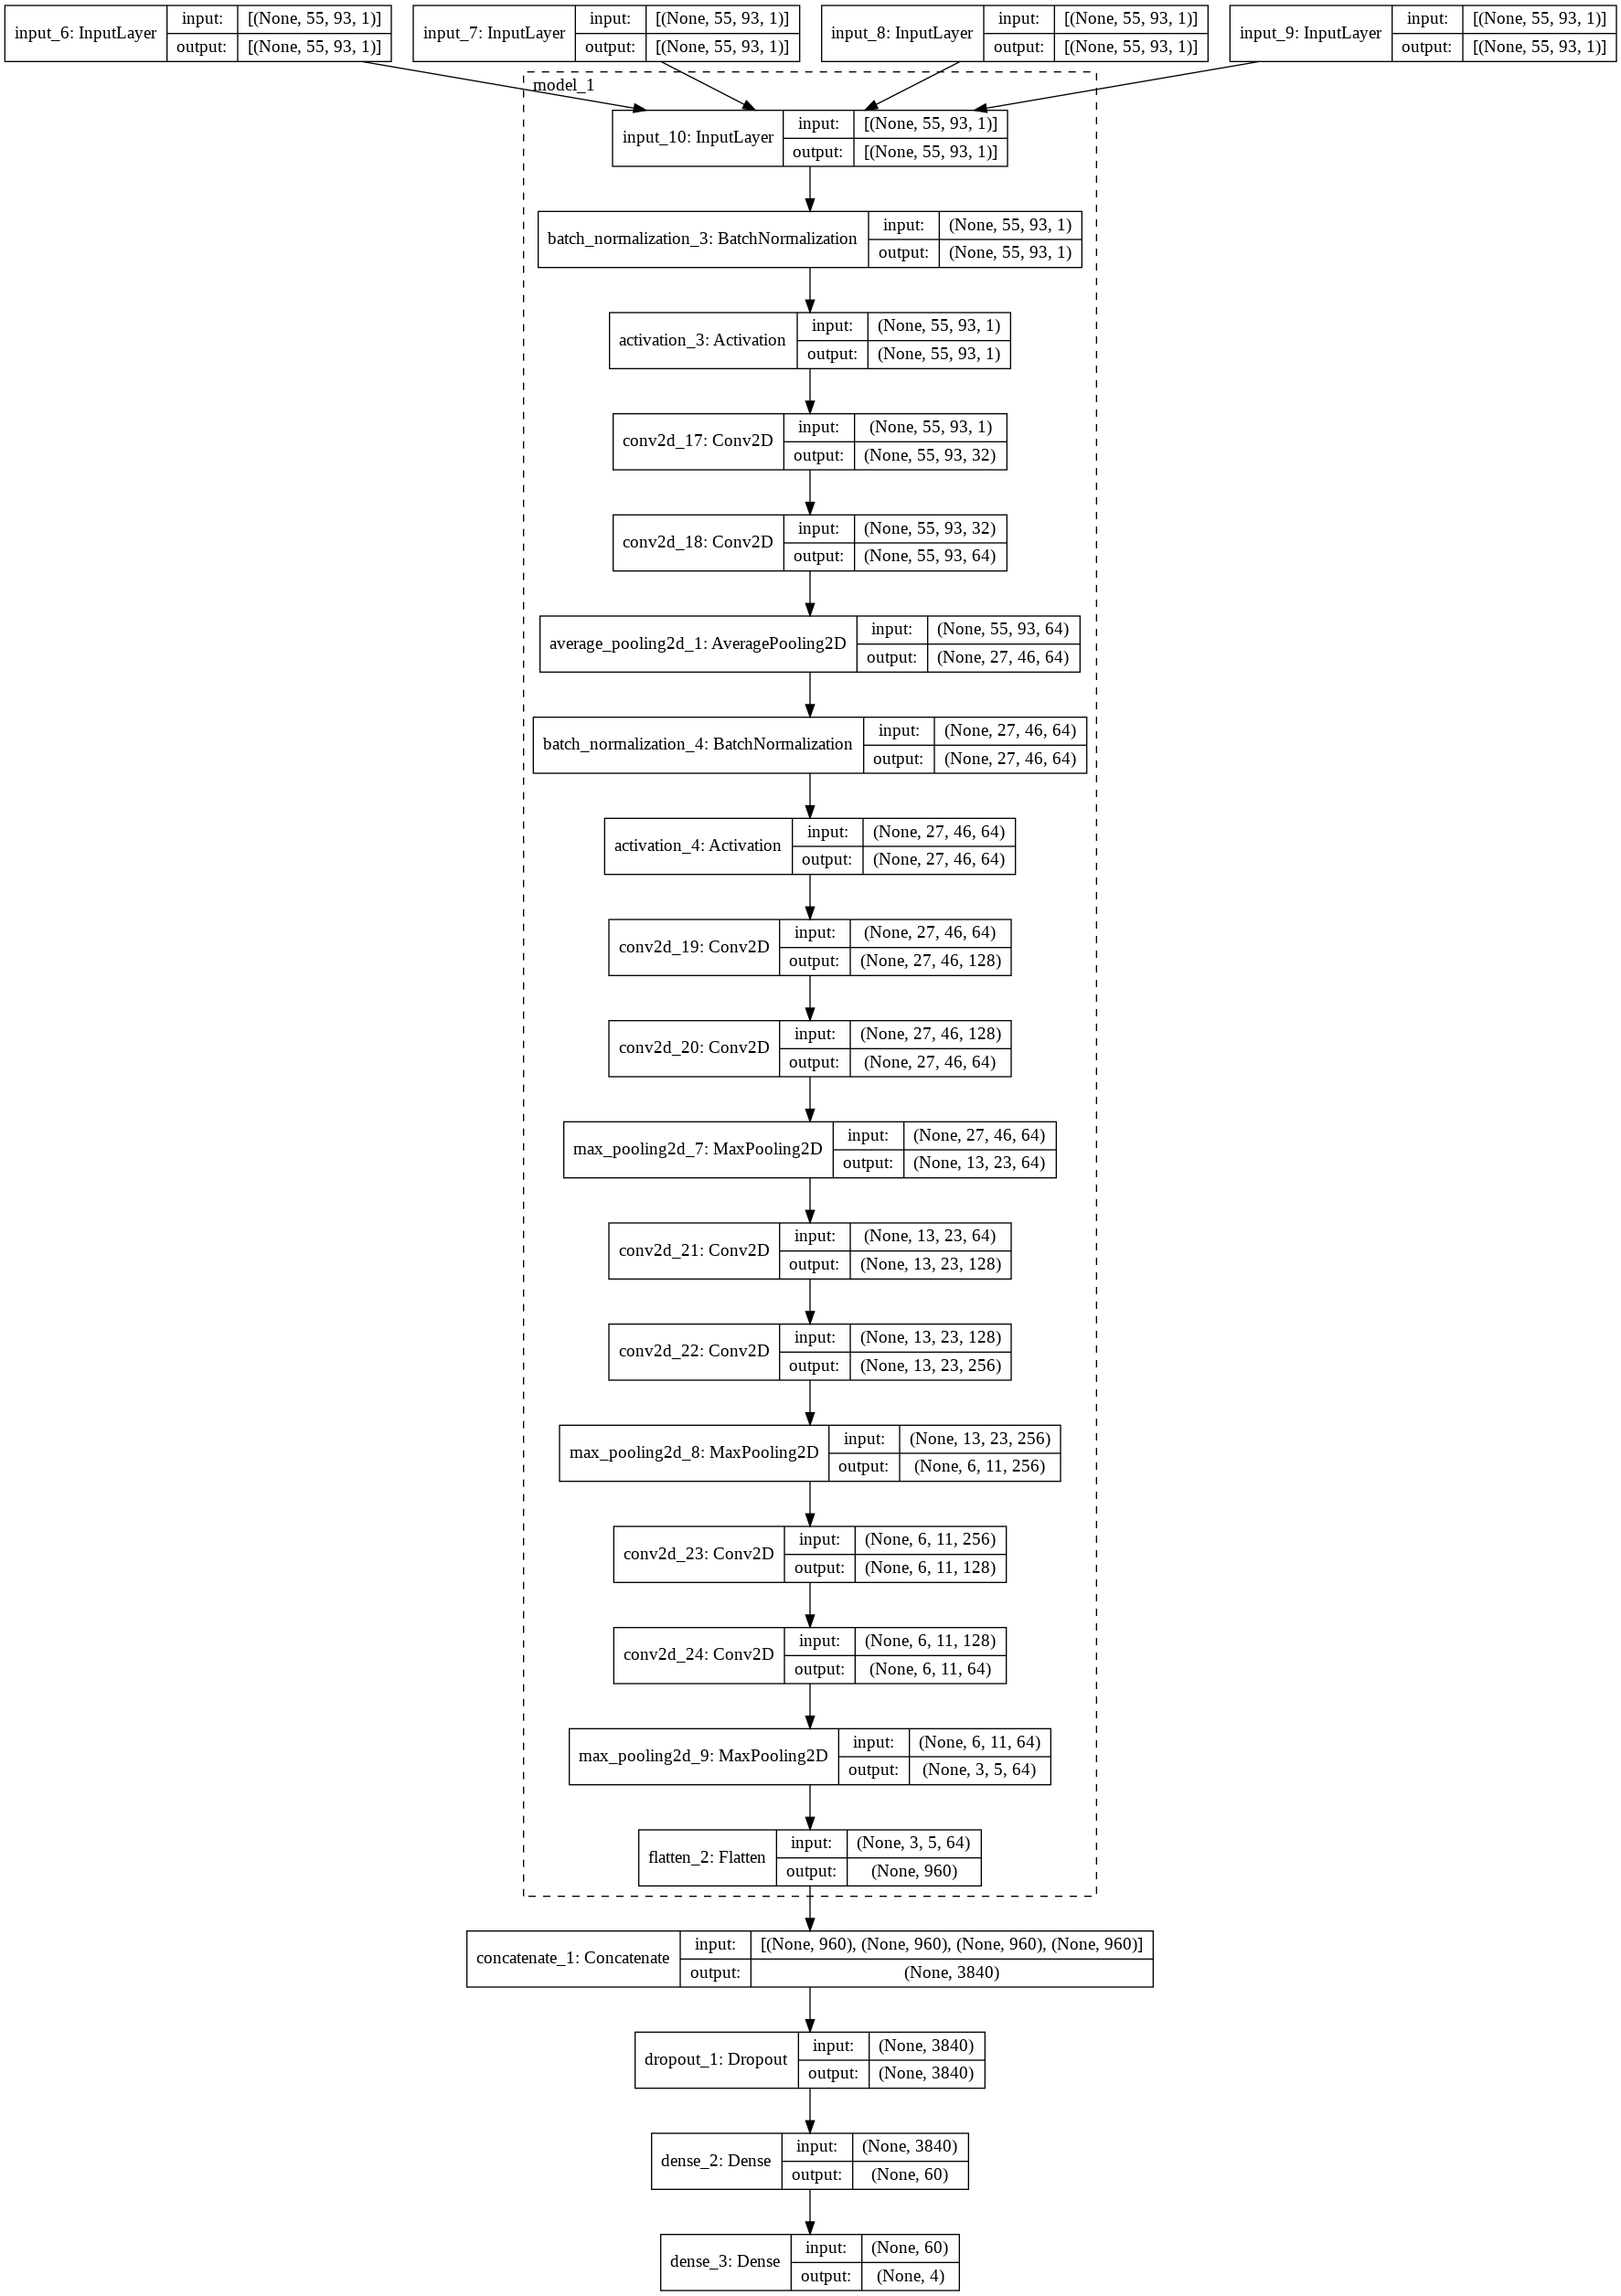

In [ ]:
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21"
#creamos el model de zero
#tenemos 4 inputs
telesc=4
input1=tf.keras.Input(shape=(55,93,1))
input2=tf.keras.Input(shape=(55,93,1))
input3=tf.keras.Input(shape=(55,93,1))
input4=tf.keras.Input(shape=(55,93,1))

#autoencoder=tf.keras.models.load_model(f"{npy_base}/autoencoder_bien.h5")
#autoencoder.trainable=False
#entran los 4 inputs y nos dan 4 outputs diferentes

#output1=autoencoder(input1)
#output2=autoencoder(input2)
#output3=autoencoder(input3)
#output4=autoencoder(input4)

#ahora los outputs los procesamos tal que todos se procesan por el mismo submodelo
aux_input=tf.keras.Input(shape=(55,93,1))
x=tf.keras.layers.BatchNormalization()(aux_input)
x=tf.keras.layers.Activation("relu")(x)
x=tf.keras.layers.Conv2D(32,(3,3),padding="same")(x)
x=tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
#x=tf.keras.layers.Activation("relu")(x)
x=tf.keras.layers.AveragePooling2D((2,2))(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Activation("relu")(x)
x=tf.keras.layers.Conv2D(128,(3,3),padding="same")(x)
x=tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
x=tf.keras.layers.MaxPool2D((2,2))(x)
x=tf.keras.layers.Conv2D(128,(3,3),padding="same")(x)
x=tf.keras.layers.Conv2D(256,(3,3),padding="same",activation="relu")(x)
x=tf.keras.layers.MaxPool2D((2,2))(x)
x=tf.keras.layers.Conv2D(128,(3,3),padding="same",activation="relu")(x)
x=tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
x=tf.keras.layers.MaxPool2D((2,2))(x)

#x=tf.keras.layers.MaxPool2D((2,2))(x)
x=tf.keras.layers.Flatten()(x)
submodel_conv=tf.keras.Model(inputs=aux_input,outputs=x)


modelito = tf.keras.models.Sequential([tf.keras.layers.Conv2D(64, 7, activation="relu", padding="same",input_shape=[55, 93, 1]),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten()])
#modelito.summary()


final_output1=submodel_conv(input1)
final_output2=submodel_conv(input2)
final_output3=submodel_conv(input3)
final_output4=submodel_conv(input4)

end_layer=tf.keras.layers.concatenate([final_output1,final_output2,final_output3,final_output4])
end_layer=tf.keras.layers.Dropout(0.5)(end_layer)
end_layer=tf.keras.layers.Dense(60)(end_layer)
end_layer=tf.keras.layers.Dense(4,activation="softmax")(end_layer)
model=tf.keras.Model(inputs=[input1,input2,input3,input4],outputs=end_layer,name="prueba_red")
model.summary()
tf.keras.utils.plot_model(model,expand_nested=True,show_shapes=True)

In [ ]:
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"
save_dir="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/ensemble"
elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']

event_aux=np.ones(len(elementos))*15
event_aux[4]=1
stop=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=14)
events=[1,11,15,15,12,15,15]
#if k ==0:
    #model=crear_modelo()
    #model=tf.keras.models.load_model(f"{save_dir}/{elementos[0]}_ensemble_2.h5")
#else:
model.compile(optimizer=tf.keras.optimizers.Adam(6e-5),loss="categorical_crossentropy",metrics=["accuracy"])
#hacemos un bucle que nos entrene atraves de muchas iteraciones
bat=64
for i in range(7):
    if i==3:
        bat=128
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
    a=create_lista_list_runs(num_events=events,init_events=[t+i*2 for t in event_aux],random_select=False)
    if i<5:
        b=False
    else:
        b=True
    x_train,x_test,y_train,y_test=load_dataset_ensemble(npy_base,["proton","helium","nitrogen"],telescopios=[6,11,4,5],lista_list_runs=a,test_size=0.15,same_quant=b) 
    hist=model.fit(x_train,y_train,epochs=55,batch_size=bat,validation_data=(x_test,y_test),callbacks=[stop])

gamma 15 [15] (4, 1997)
electron 15 [15 16 17 18 19 20 21 22 23 24 25] (4, 125)
electron 16 [15 16 17 18 19 20 21 22 23 24 25] (4, 102)
electron 17 [15 16 17 18 19 20 21 22 23 24 25] (4, 101)
electron 18 [15 16 17 18 19 20 21 22 23 24 25] (4, 122)
electron 19 [15 16 17 18 19 20 21 22 23 24 25] (4, 93)
electron 20 [15 16 17 18 19 20 21 22 23 24 25] (4, 119)
electron 21 [15 16 17 18 19 20 21 22 23 24 25] (4, 83)
electron 22 [15 16 17 18 19 20 21 22 23 24 25] (4, 108)
electron 23 [15 16 17 18 19 20 21 22 23 24 25] (4, 109)
electron 24 [15 16 17 18 19 20 21 22 23 24 25] (4, 114)
electron 25 [15 16 17 18 19 20 21 22 23 24 25] (4, 102)
proton 15 [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29] (4, 384)
proton 16 [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29] (4, 363)
proton 17 [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29] (4, 335)
proton 18 [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29] (4, 347)
proton 19 [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29] (4, 362)
proton 20 [15 16 17 18 19 20 21 

In [ ]:
a=create_lista_list_runs(num_events=[1,7,6,7,7,7,7],init_events=10,random_select=True)
x_train,x_test,y_train,y_test=load_dataset_ensemble(npy_base,["proton","helium","nitrogen"],telescopios=[6,11,4,5],lista_list_runs=a,test_size=0.15,same_quant=b) 


gamma 5 [5] (4, 1998)
electron 1 [ 1  7  9  6 16  1 16] (4, 115)
electron 7 [ 1  7  9  6 16  1 16] (4, 111)
electron 9 [ 1  7  9  6 16  1 16] (4, 114)
electron 6 [ 1  7  9  6 16  1 16] (4, 122)
electron 16 [ 1  7  9  6 16  1 16] (4, 102)
electron 1 [ 1  7  9  6 16  1 16] (4, 115)
electron 16 [ 1  7  9  6 16  1 16] (4, 102)
proton 2 [ 2 14 31 11 40  7] (4, 347)
proton 14 [ 2 14 31 11 40  7] (4, 362)
proton 31 [ 2 14 31 11 40  7] (4, 356)
proton 11 [ 2 14 31 11 40  7] (4, 363)
proton 40 [ 2 14 31 11 40  7] (4, 365)
proton 7 [ 2 14 31 11 40  7] (4, 367)
helium 20 [20 14 38 11 21 12 10] (4, 254)
helium 14 [20 14 38 11 21 12 10] (4, 229)
helium 38 [20 14 38 11 21 12 10] (4, 227)
helium 11 [20 14 38 11 21 12 10] (4, 260)
helium 21 [20 14 38 11 21 12 10] (4, 241)
helium 12 [20 14 38 11 21 12 10] (4, 227)
helium 10 [20 14 38 11 21 12 10] (4, 270)
iron 5 [ 5  4 12 20 18  2  4] (4, 145)
iron 4 [ 5  4 12 20 18  2  4] (4, 124)
iron 12 [ 5  4 12 20 18  2  4] (4, 130)
iron 20 [ 5  4 12 20 18  2  4] 

In [ ]:
model.evaluate(x_train,y_train)
comp_and_diplay_conf_matrix(y_train,model.predict(x_train),elements=["otros",'proton',"helium","nitrogen"],sin_diag=False)